In [1]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import sys
import os
import pymaster as nmt
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2
from solat_cb.data import *
from solat_cb.simulation import CMB, BandpassInt, Foreground, Mask, Noise, LATsky, SATsky

In [3]:
lib ='/pscratch/sd/l/lonappan/SOLATtest'

# Data download

In [4]:
datalist = [SAT_MASK,LAT_MASK,CO_MASK,PS_MASK,BP_PROFILE,CAMB_INI]
for d in datalist:
    d.directory = lib

In [5]:
BP_PROFILE

Data(filename='bp_profile.pkl')

# CMB simulation

In [6]:
cmb = CMB(lib,1024,0.35)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic cosmic birefringence model selected


In [7]:
E,B = hp.map2alm_spin(cmb.get_cb_lensed_QU(0),2)

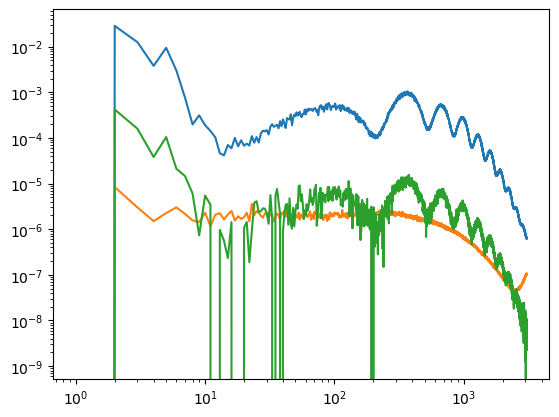

In [8]:
plt.loglog(hp.alm2cl(E),label='E')
plt.loglog(hp.alm2cl(B),label='B')
plt.loglog(hp.alm2cl(E,B),label='EB')

# Bandpass Integration

In [9]:
bp = BandpassInt(lib)

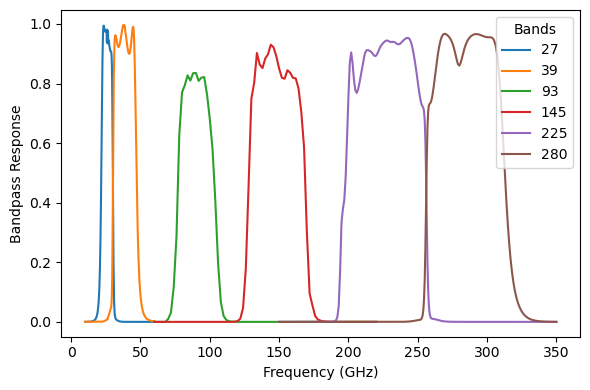

In [10]:
bp.plot_profiles()

# Foreground Simulation

In [11]:
freqs = LATsky.freqs

In [12]:
fg_wobp = Foreground(lib,512,1,1,bandpass=False,verbose=True)
fg_wbp = Foreground(lib,512,1,1,bandpass=True,verbose=True)

Foreground : INFO - Bandpass integration is disabled
Foreground : INFO - Bandpass integration is enabled


In [13]:
d1_wobp = fg_wobp.dustQU('145')
d1_wbp = fg_wbp.dustQU('145')

Foreground : INFO - Generating dust Q and U maps for band 145
Foreground : INFO - Generating dust Q and U maps for band 145


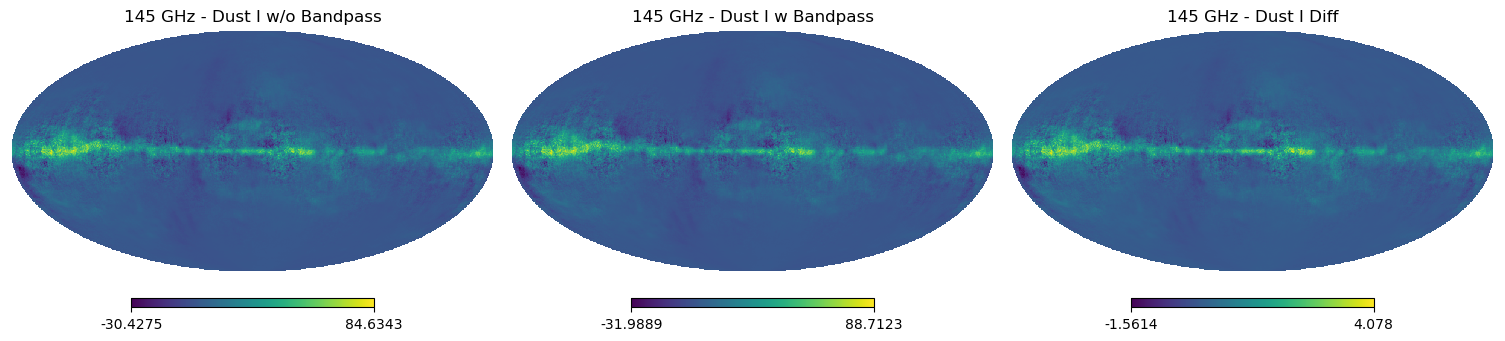

In [14]:
fig = plt.figure(figsize=(15,5))
hp.mollview(d1_wobp[0],title='145 GHz - Dust I w/o Bandpass',sub=(1,3,1))
hp.mollview(d1_wbp[0],title='145 GHz - Dust I w Bandpass',sub=(1,3,2))
hp.mollview(d1_wbp[0]-d1_wobp[0],title='145 GHz - Dust I Diff',sub=(1,3,3))

# Mask

In [5]:
nside = 512
lmax = 3*nside-1

In [6]:
LatMask = Mask(lib,nside,'LAT',apo_scale=1)
SatMask = Mask(lib,nside,'SAT')
CommonMask = Mask(lib,nside,"LATxCOxPS")

Mask : INFO - Downgrading mask LAT resolution
Mask : INFO - Apodizing mask: scale 1: method: C2
Mask : INFO - Apodizing changed the fsky 0.638 -> 0.631
Mask : INFO - Downgrading mask SAT resolution
Mask : INFO - Loading composite mask
Mask : INFO - Downgrading mask LAT resolution
Mask : INFO - Downgrading mask CO resolution
Mask : INFO - Downgrading mask PS resolution
Mask : INFO - Composite Mask LATxCOxPS: fsky changed 0.93 -> 0.59  


In [7]:
print('LAT fsky: ',LatMask.fsky)
print('SAT fsky: ',SatMask.fsky)
print('Common fsky: ',CommonMask.fsky)

LAT fsky:  0.6308744653138721
SAT fsky:  0.11703218569705914
Common fsky:  0.5916678110758463


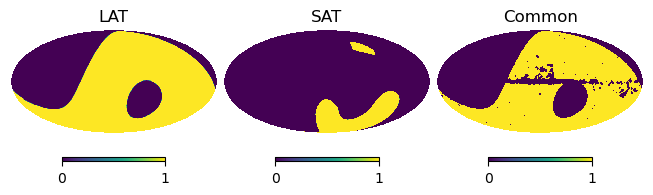

In [8]:
hp.mollview(LatMask.mask, title='LAT', sub=(1,3,1))
hp.mollview(SatMask.mask, title='SAT', sub=(1,3,2))
hp.mollview(CommonMask.mask, title='Common', sub=(1,3,3))

In [9]:
mask = LatMask.mask

In [10]:
wrk = nmt.NmtWorkspace()
mask_f = nmt.NmtField(mask, [mask, mask], lmax=lmax, purify_b=False)
binInfo = nmt.NmtBin.from_lmax_linear(lmax, 10)
wrk.compute_coupling_matrix(mask_f, mask_f, binInfo)

def compute_master(f_a,f_b):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wrk.decouple_cell(cl_coupled)
    return cl_decoupled
    
b = binInfo.get_effective_ells()

# Noise Simulation - white noise

In [12]:
n = Noise(nside,LatMask.fsky,"LAT",False,)

Noise : INFO - Noise Model:[LAT] White noise v3.1.1


In [13]:
qus = n.noiseQU()

In [14]:
q27,u27 = qus[0]
q39,u39 = qus[1]

In [15]:
f27 = nmt.NmtField(mask, [q27,u27],lmax=n.lmax, purify_b=False)
f39 = nmt.NmtField(mask, [q39,u39],lmax=n.lmax, purify_b=False)

In [16]:
ee27,_,_,bb27 = compute_master(f27,f27)
ee39,_,_,bb39 = compute_master(f39,f39)

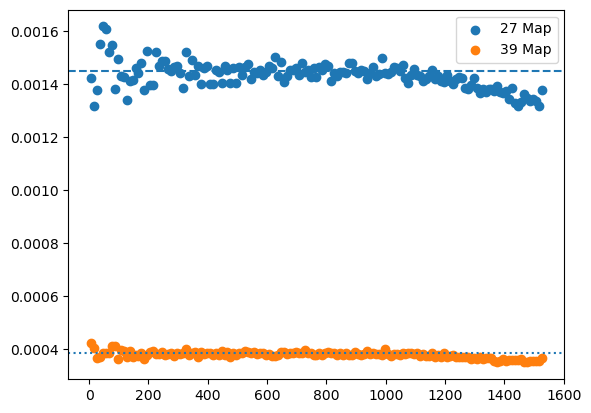

In [17]:

plt.scatter(b,ee27,label='27 Map')
plt.scatter(b,ee39,label='39 Map')
plt.axhline(n.Nell['27'][2]*2,ls='--')
plt.axhline(n.Nell['39'][2]*2,ls=':')
plt.legend()

# Noise Simulation - 1/f

In [18]:
n = Noise(nside,LatMask.fsky,"LAT",atm_noise=True)

Noise : INFO - Noise Model:[LAT] White + 1/f noise v3.1.1


In [19]:
qus = n.noiseQU()

In [20]:
q27,u27 = qus[0]
q39,u39 = qus[1]

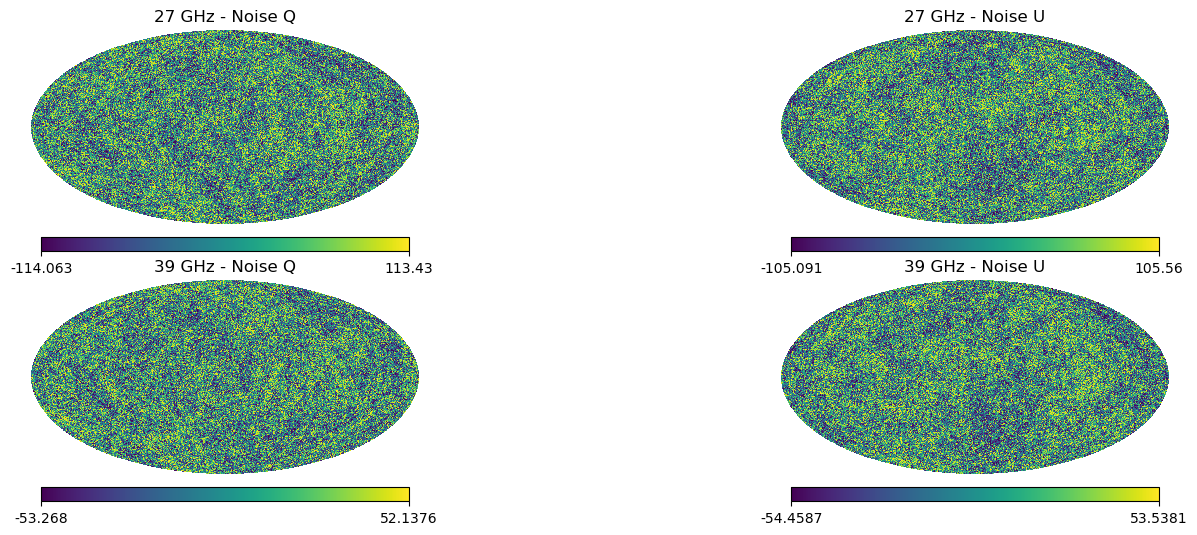

In [21]:
plt.figure(figsize=(15,10))
hp.mollview(q27,title='27 GHz - Noise Q',sub=(4,2,1),norm='hist')
hp.mollview(u27,title='27 GHz - Noise U',sub=(4,2,2),norm='hist')
hp.mollview(q39,title='39 GHz - Noise Q',sub=(4,2,3),norm='hist')
hp.mollview(u39,title='39 GHz - Noise U',sub=(4,2,4),norm='hist')

In [22]:
f27 = nmt.NmtField(mask, [q27,u27],lmax=n.lmax, purify_b=False)
f39 = nmt.NmtField(mask, [q39,u39],lmax=n.lmax, purify_b=False)

In [23]:
ee27,_,_,bb27 = compute_master(f27,f27)
ee39,_,_,bb39 = compute_master(f39,f39)
ee27_39,_,_,bb27_39 = compute_master(f27,f39)

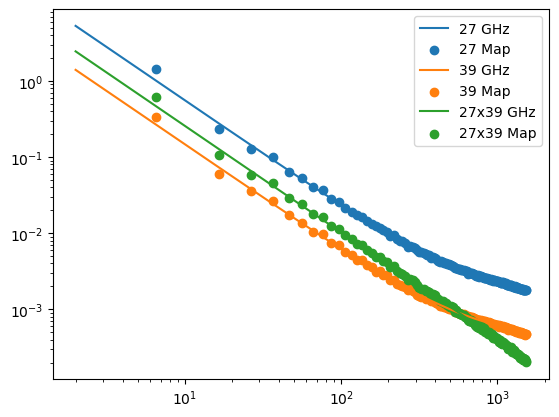

In [24]:
plt.loglog(n.Nell['ell'],n.Nell['27']*2,label='27 GHz')
plt.scatter(b,ee27,label='27 Map')
plt.loglog(n.Nell['ell'],n.Nell['39']*2,label='39 GHz')
plt.scatter(b,ee39,label='39 Map')
plt.loglog(n.Nell['ell'],n.Nell['27x39']*2,label='27x39 GHz')
plt.scatter(b,ee27_39,label='27x39 Map')
plt.legend()

# Noise SAT 

In [25]:
n = Noise(nside,SatMask.fsky,"SAT",atm_noise=True)

/pscratch/sd/l/lonappan/software_pkgs/cb/lib/python3.10/site-packages/so_models_v3/SO_Noise_Calculator_Public_v3_1_1.py:215: RuntimeWarning: divide by zero encountered in scalar divide
  cov_weight[i,j] += ( tube_count * N_tels /
Noise : INFO - Noise Model:[SAT] White + 1/f noise v3.1.1


In [26]:
qus = n.noiseQU()
q27,u27 = qus[2]
q39,u39 = qus[3]
f27 = nmt.NmtField(mask, [q27,u27],lmax=n.lmax, purify_b=False)
f39 = nmt.NmtField(mask, [q39,u39],lmax=n.lmax, purify_b=False)
ee27,_,_,bb27 = compute_master(f27,f27)
ee39,_,_,bb39 = compute_master(f39,f39)

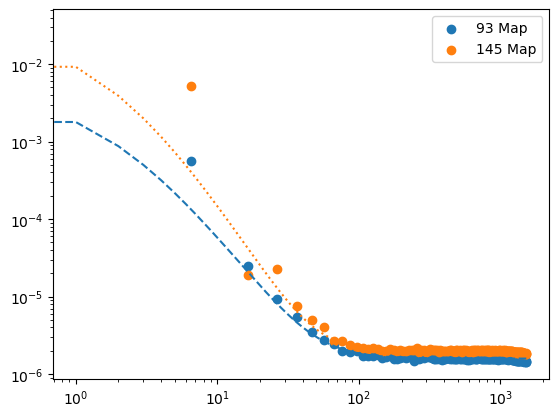

In [28]:

plt.scatter(b,ee27,label='93 Map')
plt.scatter(b,ee39,label='145 Map')
plt.loglog(n.Nell['93']*2,ls='--')
plt.loglog(n.Nell['145']*2,ls=':')
plt.legend()

In [78]:
alpha = [0.1,0.1,0.3,0.3,.2,.2]

In [35]:
nside = 512
cb_method = 'iso'

# LAT sky simulation

In [36]:
lat = LATsky(lib,nside,cb_method,1,1,alpha,0.35,verbose=True)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic cosmic birefringence model selected
Mask : INFO - Downgrading mask LAT resolution
Noise : INFO - Noise Model: White noise v3.0.0


In [37]:
lat_map = lat.obsQU(0,'27-1')

Saving Observed QUs: 100%|██████████| 12/12 [00:02<00:00,  5.95band/s]


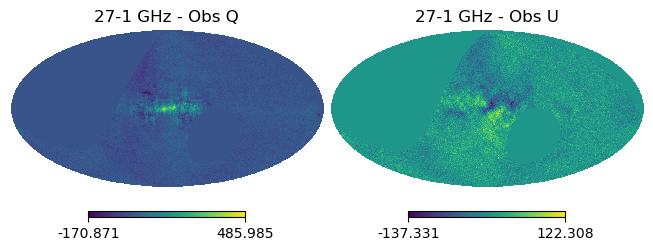

In [38]:
hp.mollview(lat_map[0],title='27-1 GHz - Obs Q',sub=(1,2,1))
hp.mollview(lat_map[1],title='27-1 GHz - Obs U',sub=(1,2,2))

# SAT sky simulation

In [39]:
sat = SATsky(lib,nside,cb_method,1,1,alpha,0.35,verbose=True)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Isotropic cosmic birefringence model selected


Mask : INFO - Downgrading mask SAT resolution
/pscratch/sd/l/lonappan/software_pkgs/cb/lib/python3.10/site-packages/so_models_v3/SO_Noise_Calculator_Public_v3_1_1.py:215: RuntimeWarning: divide by zero encountered in scalar divide
  cov_weight[i,j] += ( tube_count * N_tels /
Noise : INFO - Noise Model: White noise v3.0.0


In [40]:
sat_map = sat.obsQU(0,'30-1')

Saving Observed QUs: 100%|██████████| 12/12 [00:02<00:00,  5.71band/s]


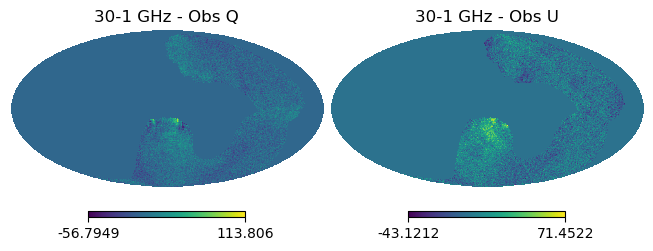

In [41]:
hp.mollview(sat_map[0],title='30-1 GHz - Obs Q',sub=(1,2,1))
hp.mollview(sat_map[1],title='30-1 GHz - Obs U',sub=(1,2,2))

# Noise Diff

In [42]:
natm =  Noise(2048,LatMask.fsky,"LAT",atm_noise=True).Nell
nwht =  Noise(2048,LatMask.fsky,"LAT",atm_noise=False).Nell

Noise : INFO - Noise Model: White + 1/f noise v3.0.0
Noise : INFO - Noise Model: White noise v3.0.0


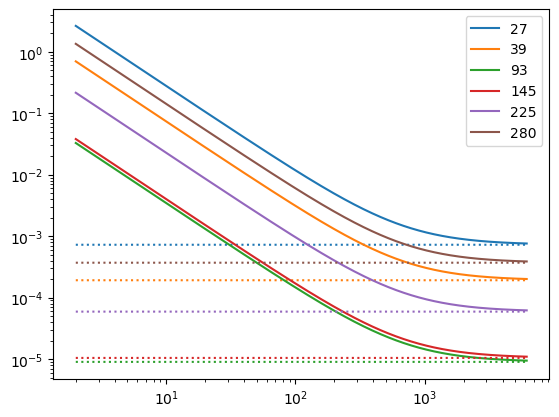

In [43]:
ell = natm['ell']
for i,fs in enumerate(lat.freqs):
    plt.loglog(ell,natm[f'{fs}'],c=f"C{i}",label=f'{fs}')
    plt.loglog(ell,nwht[f'{fs}'],c=f"C{i}",ls=':')
plt.legend()

# LAT sky with anisotropic CB and HILC

In [50]:
lat_aniso = LATsky(lib,nside,'aniso',1,1,alpha,Acb=1e-4,verbose=True,nsplits=1)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
Mask : INFO - Downgrading mask LAT resolution
Noise : INFO - Noise Model: White noise v3.0.0


In [54]:
cmb_alms,ncl_eb = lat_aniso.HILC_obsEB(0)

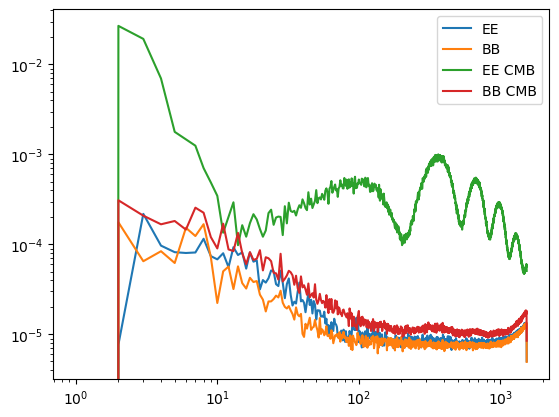

In [56]:
plt.loglog(ncl_eb[0],label='EE')
plt.loglog(ncl_eb[1],label='BB')
plt.loglog(hp.alm2cl(cmb_alms[0]),label='EE CMB')
plt.loglog(hp.alm2cl(cmb_alms[1]),label='BB CMB')
plt.legend()

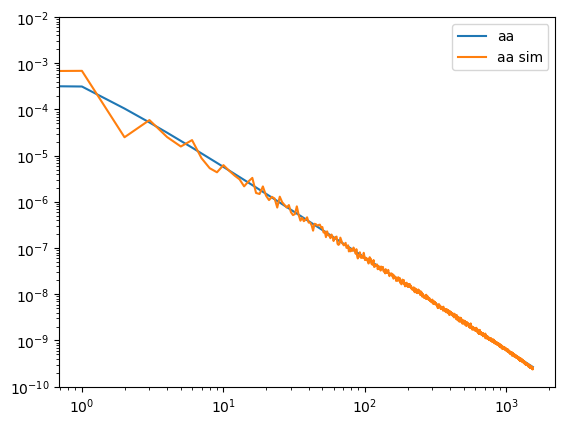

In [60]:
plt.loglog(lat_aniso.cmb.cl_aa(),label='aa')
plt.loglog(hp.anafast(lat_aniso.cmb.alpha_map(0)),label='aa sim')
plt.ylim(1e-10,1e-2)
plt.legend()